In [1]:
%matplotlib inline
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import xarray as xr
from scipy.interpolate import interp1d

from mmctools.helper_functions import T_to_Tv, T_to_theta
from mmctools.plotting import plot_timehistory_at_height, plot_profile

# Estimate hub-height turbulence intensity
Using:
* Balloon-borne sounding system (`SONDEWNPN`)
> Atmospheric Radiation Measurement (ARM) user facility. 2001, updated hourly. Balloon-Borne Sounding System (SONDEWNPN). 2018-06-03 to 2018-06-27, Southern Great Plains (SGP) Central Facility, Lamont, OK (C1). Compiled by E. Keeler, J. Kyrouac and D. Holdridge. ARM Data Center. Data set accessed 2020-09-09 at http://dx.doi.org/10.5439/1021460.
* eddy correlation flux measurement system (`30ECOR`)
> Atmospheric Radiation Measurement (ARM) user facility. 2003, updated hourly. Eddy Correlation Flux Measurement System (30ECOR). 2018-06-03 to 2018-06-27, Southern Great Plains (SGP) Lamont, OK (Extended, secondary) (E14). Compiled by R. Sullivan, D. Cook and E. Keeler. ARM Data Center. Data set accessed 2020-09-04 at http://dx.doi.org/10.5439/1025039.

Approach:
1. Calculate profiles of potential temperature from soundings, which will be regularized to a duration of 10 minutes and averaged up to 
2. Estimate the atmospheric boundary layer height ($z_i$) as height above ground level to the base of the temperature inversion layer
3. Extrapolate streamwise velocity variances from near-ground measurements up to hub height using similarity theory, i.e., Eqns. 9.4.3e, 9.5.3d, and 9.6.3a from Stull 1988 for stable, neutral, and convective conditions, respectively
4. Calculate hub-height TI from extrapolated variance and power-law-modeled hub-height wind speed

Written by Eliot Quon (eliot.quon@nrel.gov)

In [2]:
# hub-height wind, stability, u*, and variance of u from `June2018_analysis.ipynb`
atmos_data = 'data/ARM_June2018_atmospheric_conditions.0.nc'

In [3]:
sounding_prefix = '/Users/equon/OneDrive - NREL/AWAKEN/ARM/sondewnpn/sgpsondewnpnC1.b1'

In [4]:
startdate = pd.to_datetime('2018-06-03')
enddate = pd.to_datetime('2018-06-26')
UTCoffset = -5
UTC_to_local = pd.to_timedelta(UTCoffset,unit='h')

In [5]:
zhub = 80.
zref = 3.0 # height at which <u'u'> is known from ecor system

In [6]:
# interpolate sounding heights to these values
zmax = 2000.
dz = 5.

In [7]:
# ad hoc value for minimum inversion height (for automatically identifying the ABL height)
zinvmin = 100.

## 1. Load data and calculate potential temperature profiles

In [8]:
atmos = xr.open_dataset(atmos_data)

In [9]:
# workaround for later atmos.to_netcdf() ValueError:
# Variable ... has conflicting _FillValue (nan) and missing_value (-9999.0). Cannot encode data.
atmos['var_rot_u'].encoding['missing_value'] = np.nan
atmos['ustar'].encoding['missing_value'] = np.nan

In [10]:
# elevation lookup from, e.g., https://nationalmap.gov/epqs/
def process_sounding(fpath,timeoffset='10min',elevation=312.32,
                     heights=np.arange(dz,zmax+dz,dz)):
    ds = xr.open_dataset(fpath)
    
    # setup datetimes
    t0 = ds.coords['time'].values[0]
    t1 = t0 + pd.to_timedelta(timeoffset)
    ds = ds.sel(time=slice(t0,t1))
    
    # calculate potential temperature profile
    Tv = T_to_Tv(ds['tdry'], Td=ds['dp'], p=ds['pres'], celsius=True) + 273.15 # [K]
    ds['thetav'] = xr.DataArray(T_to_theta(Tv, ds['pres']),
                                dims='time', 
                                attrs={'long_name':'Virtual potential temperature (pref=1000 hPa)', 'units':'K'}
                               )
    
    # update coordinates
    ds['datetime'] = xr.DataArray([ds['time'].values[0]],
                                  dims='datetime',
                                  attrs={'long_name':'Date/time at launch'})
    ds['height'] = xr.DataArray(ds['alt'] - elevation,
                                dims='time', 
                                attrs={'long_name':'Height above ground level', 'units':'m'}
                               )
    ds = ds.assign_coords(height=ds['height'])
    ds = ds.swap_dims({'time':'height'})
    
    # check if heights are unique
    # - this is a known issue for sgpsondewnpnC1.b1.20180624.173300.cdf
    _, uniqueidx = np.unique(ds.coords['height'], return_index=True)
    if not len(ds.coords['height']) == len(uniqueidx):
        print('Note: dropping duplicate heights in',fpath)
        ds = ds.isel(height=uniqueidx)
    
    # return dataset at regular heights
    ds = ds.interp(height=heights)
    return ds

In [11]:
soundingfiles = glob.glob(sounding_prefix+'*.cdf')
soundingfiles.sort()

%time dslist = [process_sounding(fpath) for fpath in soundingfiles]

# CPU times: user 4.97 s, sys: 176 ms, total: 5.15 s
# Wall time: 5.59 s

Note: dropping duplicate heights in /Users/equon/OneDrive - NREL/AWAKEN/ARM/sondewnpn/sgpsondewnpnC1.b1.20180624.173300.cdf
CPU times: user 5.21 s, sys: 206 ms, total: 5.42 s
Wall time: 5.89 s


In [12]:
soundings = xr.concat(dslist,dim='datetime')
soundings.to_netcdf(f'data/ARM_June2018_sounding_profiles_to_{zmax:g}m_AGL.nc')

## 2. Estimate temperature inversion height
After some trial and error, a two-stage rolling median filter seems to produce a halfway reasonable initial guess--plenty of room for improvement here, though... _Note: $z_i$ is only used for stable and neutral conditions._

In [13]:
dTdz = soundings['thetav'].rolling(height=5).median().differentiate('height')
dTdz = dTdz.rolling(height=50).median()
dTdz = dTdz.sel(height=slice(zinvmin,None))
dTdz.name = 'Tgrad'

/Users/equon/anaconda3/envs/forge/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [14]:
# select zi as the first local maxima in dT/dz
zi = dTdz.idxmax(dim='height')
zi.attrs = {'long_name':'Estimated boundary layer height', 'units':'m'}
zi.name = 'zi'
zi.to_dataframe().to_csv('data/ARM_June2018_zi_est.csv')

### 2a. Need to manually QC and correct the estimated $z_i$

In [15]:
if os.path.isfile('data/ARM_June2018_zi_est_manualqc.csv'):
    zi_qc = pd.read_csv('data/ARM_June2018_zi_est_manualqc.csv',parse_dates=['datetime'],index_col=0)
    zi[:] = zi_qc['zi']
    print('loaded manually QCed z_i estimates')

loaded manually QCed z_i estimates


In [16]:
sondehist = xr.Dataset({'zi':zi})
sondehist['thetav'] = xr.DataArray(
    [Tprof.sel(height=zval) for zval,Tprof in zip(zi.values,soundings['thetav'])],
    dims='datetime',
    attrs=soundings['thetav'].attrs
)
sondehist['Tgrad'] = xr.DataArray(
    [Tgrad.sel(height=zval) for zval,Tgrad in zip(zi.values,dTdz)],
    dims='datetime',
    attrs={'long_name':'Virtual potential temperature gradient', 'units':'K/m'}
)

### 2b. Visual check

In [17]:
os.makedirs('figures',exist_ok=True)

/Users/equon/a2e-mmc/mmctools/mmctools/plotting.py:1645: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(nrows=nrows,ncols=ncols,sharex=sharex,sharey=sharey,figsize=(subfigsize[0]*ncols,subfigsize[1]*nrows))


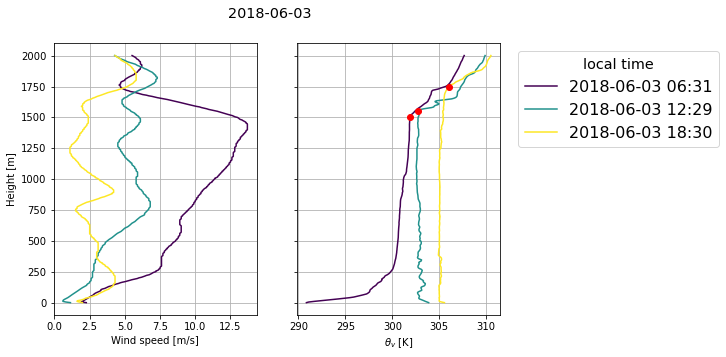

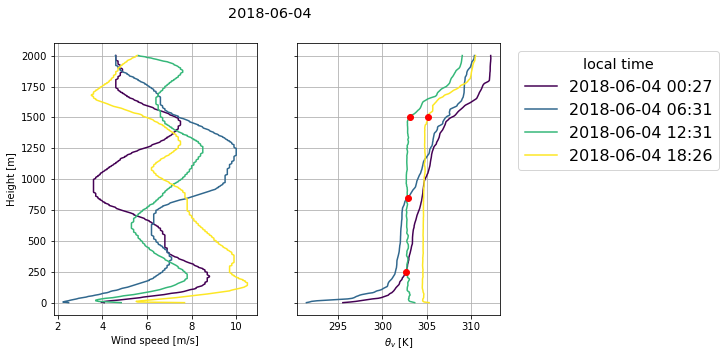

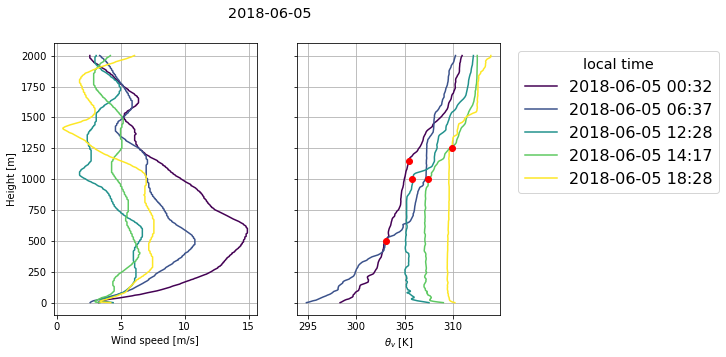

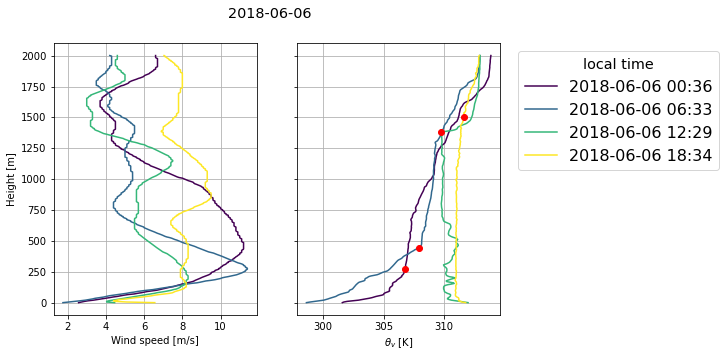

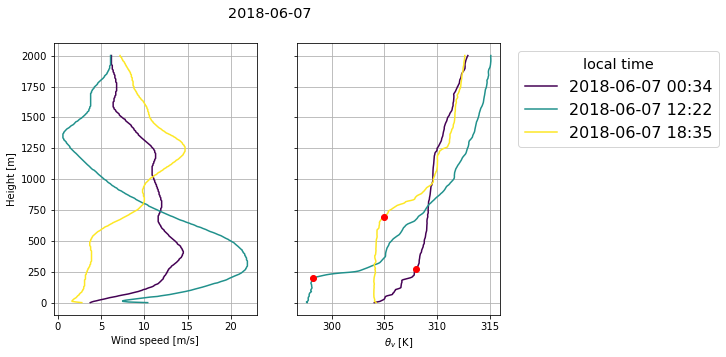

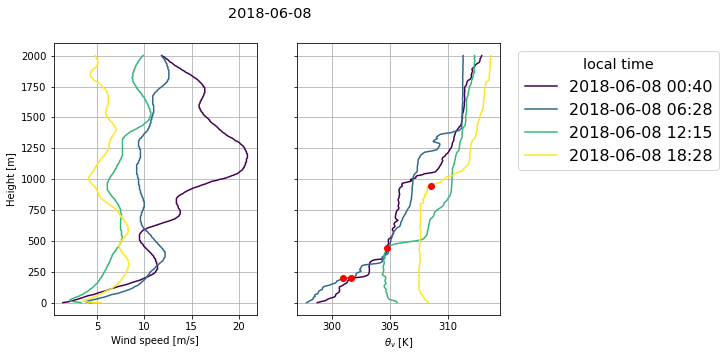

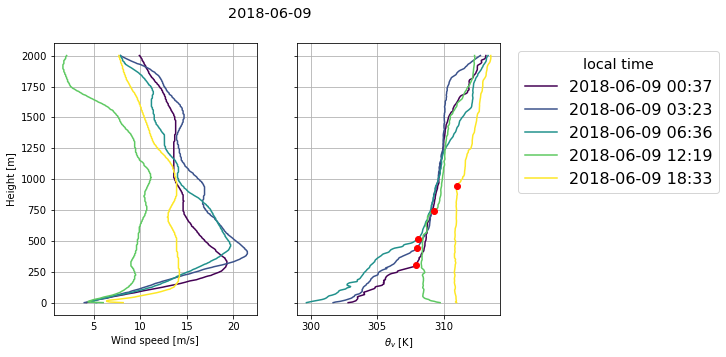

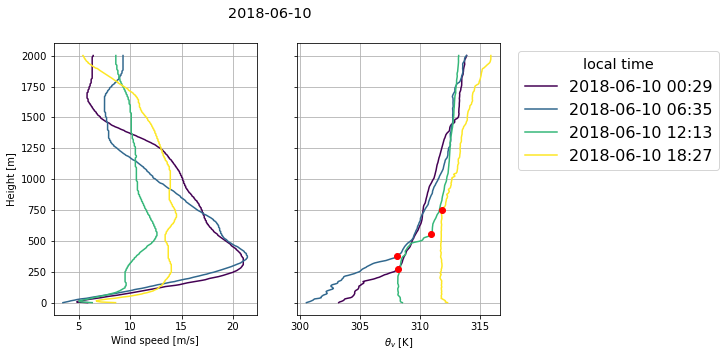

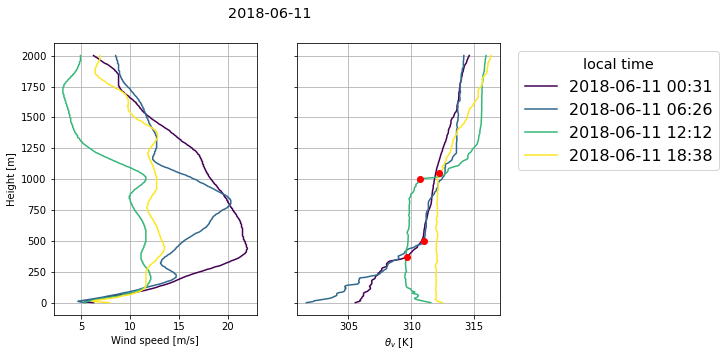

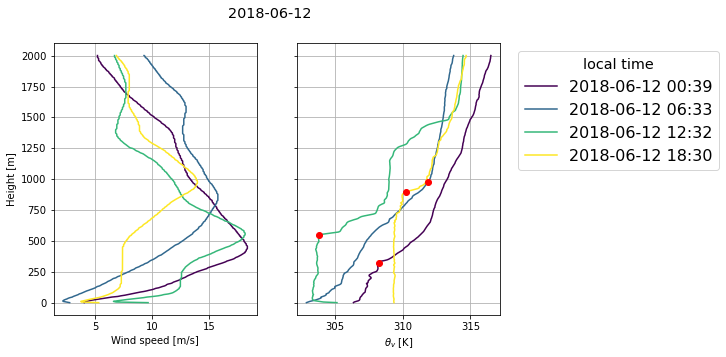

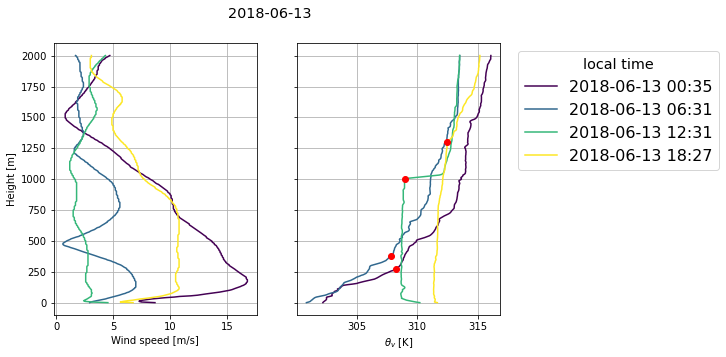

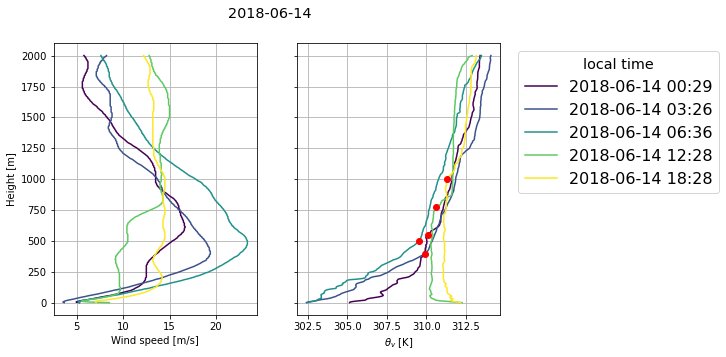

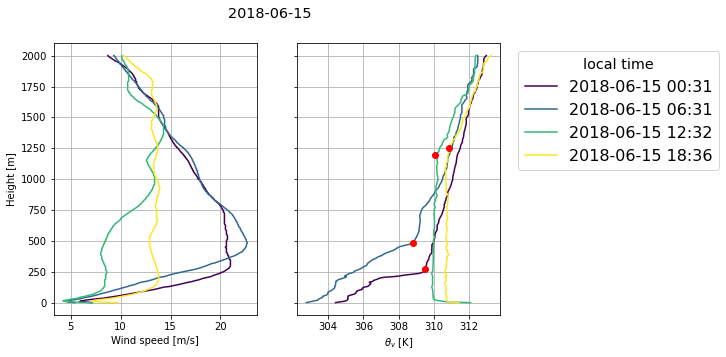

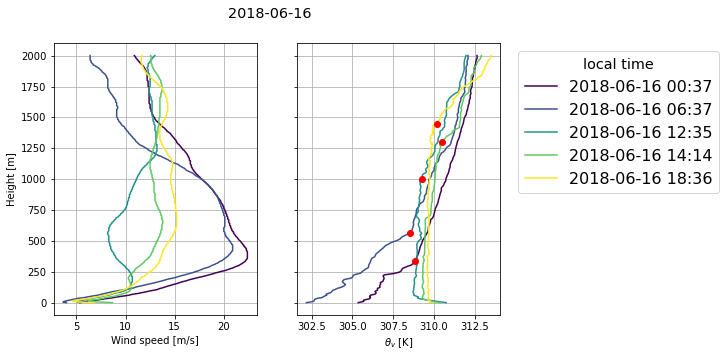

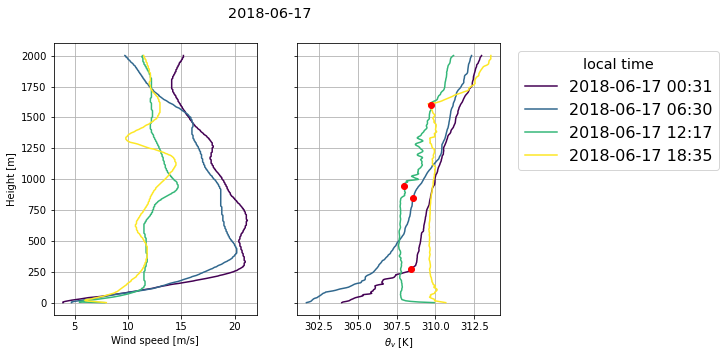

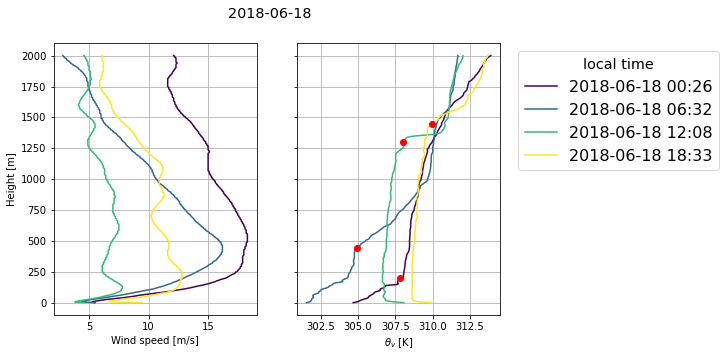

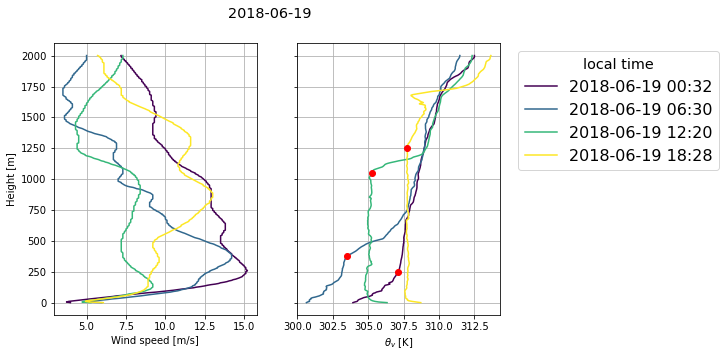

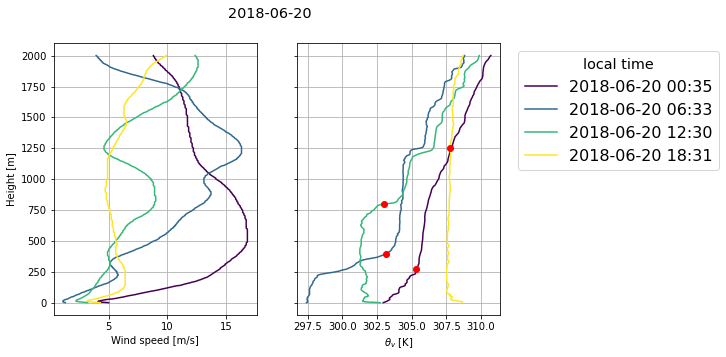

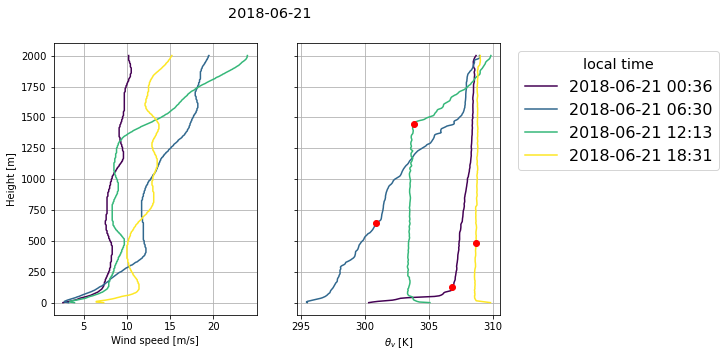

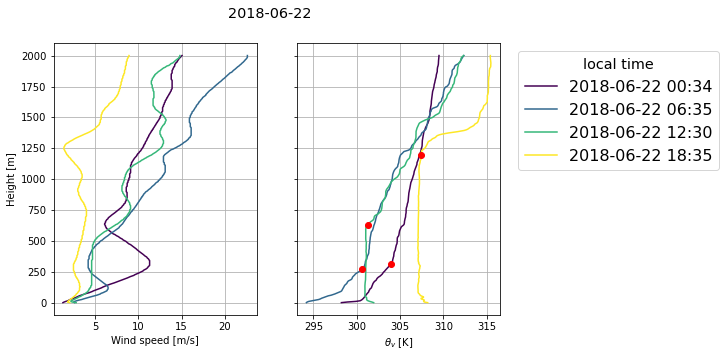

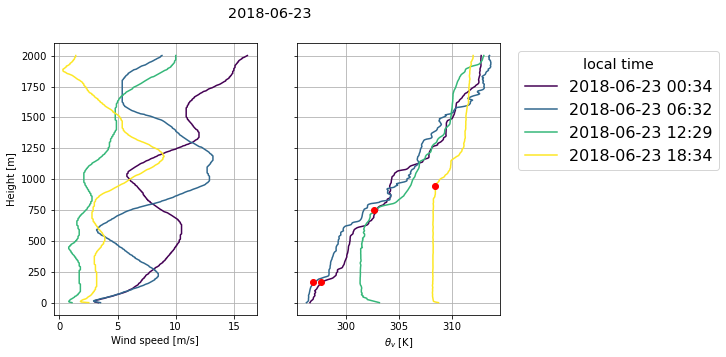

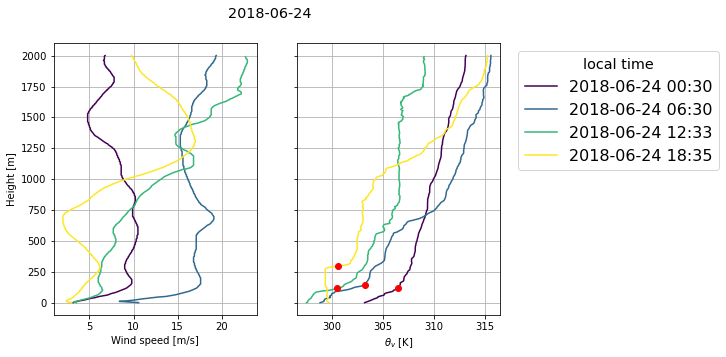

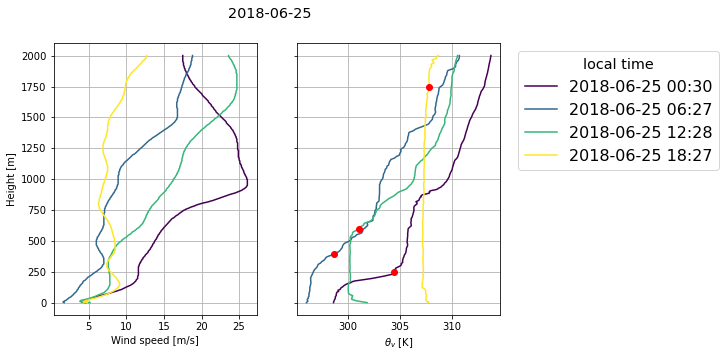

In [18]:
dateranges = pd.date_range(startdate,enddate,freq='D')
for daystart,dayend in zip(dateranges[:-1], dateranges[1:]):
    day = daystart.strftime('%Y-%m-%d')
    dayhist = sondehist.sel(datetime=slice(daystart,dayend))
    profiles = soundings.sel(datetime=slice(daystart,dayend))
    timesinday = profiles.coords['datetime'].values
    fig,ax = plot_profile(profiles,
                          fields=['wspd','thetav'],
                          times=timesinday+UTC_to_local,
                          plot_local_time=True, local_time_offset=UTCoffset,
                          cmap='viridis')
    ax[1].plot(dayhist['thetav'],dayhist['zi'],'ro')
    fig.suptitle(day,fontsize='x-large')
    lgd = ax[-1].get_legend()
    lgd.set_title('local time',prop={'size':'x-large'})
    fig.savefig(f'figures/U_T_profiles_{day}.png',bbox_inches='tight')

### 2c. resample to match atmospheric data

In [19]:
zihist = sondehist['zi'].interp(datetime=atmos.coords['time'])

In [20]:
# set last missing value
zihist[-1] = sondehist['zi'].isel(datetime=-1)
print('set zi at time',zihist[-1].coords['time'].values,'from',sondehist.coords['datetime'].values[-1])

set zi at time 2018-06-26T23:30:00.000000000 from 2018-06-26T23:26:00.000000000


In [21]:
atmos['zi'] = zihist

## 3. Extrapolate variance to hub height

In [22]:
is_stable = np.where(atmos['stability']=='s')
is_neutral = np.where(atmos['stability']=='n')
is_unstable = np.where(atmos['stability']=='u')
notna = np.where(~pd.isna(atmos['L']))

In [23]:
def estimate_uu(z,nbl_uvar_ratio=2.0,cbl_const=1.0):
    uu_est = np.empty_like(atmos['ustar'])
    znorm = z / atmos['zi'].values # z/h for stable BL or z/zi for neutral,convective
    uu_est[is_stable] = 6*np.maximum(1 - znorm[is_stable]**0.5, 0)
    uu_est[is_neutral] = 6*(1 - znorm[is_neutral])**2 + znorm[is_neutral]*nbl_uvar_ratio
    uu_est[is_unstable] = cbl_const
    # don't return questioanble values
    uu_est[notna] = uu_est[notna] * atmos['ustar'].values[notna]**2
    return uu_est

In [24]:
est_uu_ref = estimate_uu(zref)

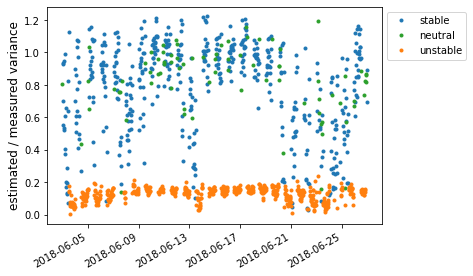

In [25]:
uu_ref_ratio = est_uu_ref / atmos['var_rot_u']
uu_ref_ratio[is_stable].plot(linestyle='none',marker='.',color='tab:blue',label='stable')
uu_ref_ratio[is_neutral].plot(linestyle='none',marker='.',color='tab:green',label='neutral')
uu_ref_ratio[is_unstable].plot(linestyle='none',marker='.',color='tab:orange',label='unstable')
plt.xlabel('')
plt.ylabel('estimated / measured variance',fontsize='large')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))

### 3a. Need to estimate the mixed layer scaling constant (in Stull 9.6.3a)
This is a bit ad hoc, choose consistent unstable period

In [26]:
uns_to_fit = np.where((atmos['stability']=='u') 
                      & (atmos.coords['time'] >= pd.to_datetime('2018-06-15'))
                      & (atmos.coords['time'] < pd.to_datetime('2018-06-20')))

In [27]:
scalefac = 1.0 / uu_ref_ratio[uns_to_fit].values.mean()
scalefac

6.606862018209493

In [28]:
est_uu_ref = estimate_uu(zref,cbl_const=scalefac)

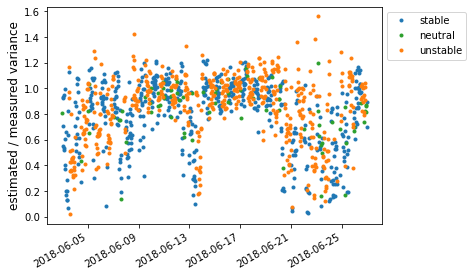

In [29]:
uu_ref_ratio = est_uu_ref / atmos['var_rot_u']
uu_ref_ratio[is_stable].plot(linestyle='none',marker='.',color='tab:blue',label='stable')
uu_ref_ratio[is_neutral].plot(linestyle='none',marker='.',color='tab:green',label='neutral')
uu_ref_ratio[is_unstable].plot(linestyle='none',marker='.',color='tab:orange',label='unstable')
plt.xlabel('')
plt.ylabel('estimated / measured variance',fontsize='large')
plt.legend(loc='upper left',bbox_to_anchor=(1,1))

Text(0.5, 1.0, 'z = 3 m')

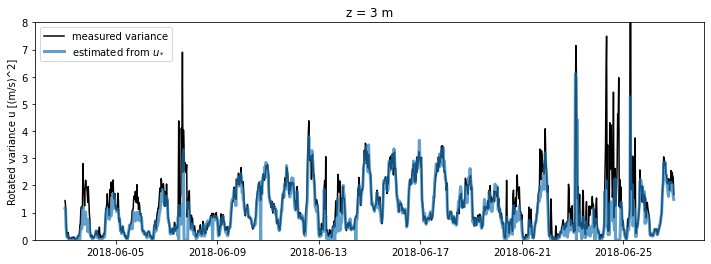

In [30]:
fig,ax = plt.subplots(figsize=(12,4))
times = atmos['var_rot_u'].coords['time']
ax.plot(times,atmos['var_rot_u'],color='k',label='measured variance')
ax.plot(times,est_uu_ref,lw=3,alpha=0.7,label=f'estimated from $u_*$')
ax.set_ylim((0,8))
ax.legend()
longname = atmos['var_rot_u'].attrs['long_name']
units = atmos['var_rot_u'].attrs['units']
ax.set_xlabel('')
ax.set_ylabel(f'{longname} [{units}]')
ax.set_title(f'z = {zref:g} m')

## 4. finally, calculate TI

In [31]:
est_uu_hub = estimate_uu(zhub,cbl_const=scalefac)

In [32]:
atmos['TI'] = 100 * np.sqrt(est_uu_hub) / atmos['Uhub']

In [33]:
atmos['TI'].attrs['long_name'] = 'hub-height (z={:zhub} m) turbulence intensity estimated from u*'
atmos['TI'].attrs['unit'] = '%'

In [34]:
# clean up
atmos['TI'][np.where(atmos['TI'] > 100)] = np.nan

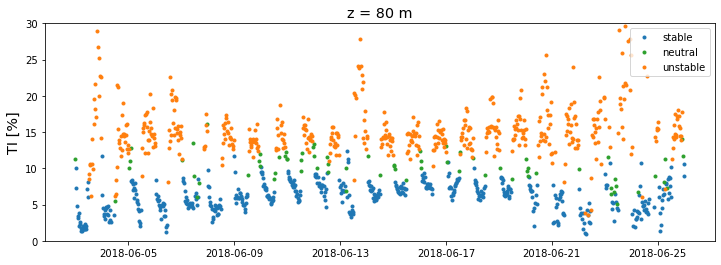

In [35]:
fig,ax = plt.subplots(figsize=(12,4))
#ax.plot(times,atmos['TI'],label=f'estimate from $u_
ax.plot(times[is_stable],atmos['TI'][is_stable],'.',color='tab:blue',label='stable')
ax.plot(times[is_neutral],atmos['TI'][is_neutral],'.',color='tab:green',label='neutral')
ax.plot(times[is_unstable],atmos['TI'][is_unstable],'.',color='tab:orange',label='unstable')
ax.set_ylim((0,30))
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('TI [%]', fontsize='x-large')
ax.set_title(f'z = {zhub:g} m', fontsize='x-large')
fig.savefig(f'figures/TI_hist.png',bbox_inches='tight')

In [36]:
# write out complete dataset
atmos.to_netcdf('data/ARM_June2018_atmospheric_conditions.1.nc')